### SDS-043-CardioSentinel: Predicting Heart Attack Risk from Lifestyle and Clinical Data

This notebook performs standard feature engineering per the README: split out or combine columns, formulas, binning, encodings, and preprocessing plan.

Feature Engineering  
Source:  https://www.kaggle.com/datasets/iamsouravbanerjee/heart-attack-prediction-dataset  
Greg Gibson Nov. 2025

### Feature Exclusion / Transformation

- 'duration' removed (leakage)
- Outliers capped per EDA: balance, campaign, previous, pdays
- pdays transformed to never_contacted + recency
- Ordinal encoding for education
- One-hot encoding for categorical features

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

In [100]:
# Load dataset, try both likely locations
possible_paths = [
    Path('..') / 'data' / 'raw' / 'heart_attack_prediction_dataset.csv',  # when running from notebooks/
    Path('data') / 'raw' / 'heart_attack_prediction_dataset.csv'          # when running from project root
]

data_path = next((p for p in possible_paths if p.exists()), None)

if data_path is None:
    raise FileNotFoundError("Could not find heart_attack_prediction_dataset.csv in expected locations.")

print("Using data file:", data_path)
df = pd.read_csv(data_path)

# Quick look
print('Shape:', df.shape)
display(df.head())

Using data file: ..\data\raw\heart_attack_prediction_dataset.csv
Shape: (8763, 26)


,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [101]:
# Drop Patient ID as it's not predictive
df = df.drop(columns=['Patient ID'])

Column types and grouping

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8763 non-null   int64  
 1   Sex                              8763 non-null   object 
 2   Cholesterol                      8763 non-null   int64  
 3   Blood Pressure                   8763 non-null   object 
 4   Heart Rate                       8763 non-null   int64  
 5   Diabetes                         8763 non-null   int64  
 6   Family History                   8763 non-null   int64  
 7   Smoking                          8763 non-null   int64  
 8   Obesity                          8763 non-null   int64  
 9   Alcohol Consumption              8763 non-null   int64  
 10  Exercise Hours Per Week          8763 non-null   float64
 11  Diet                             8763 non-null   object 
 12  Previous Heart Probl

In [103]:
# Function to identify column type groups

def infer_column_groups(
    df: pd.DataFrame,
    target_col: str = None,
    max_cat_unique: int = 20,
    force_numeric=None,
    force_ordinal=None,
    force_categorical=None
):
    """
    Infer column groups for ML preprocessing.

    Groups:
      - numeric: continuous or count-like numbers
      - binary: 0/1 or True/False
      - categorical: nominal categories (no order)
      - ordinal: ordered categories (levels, ratings, small scales)
      - ignore: target or unknown types
    
    Parameters
    ----------
    df : DataFrame
    target_col : str, optional
        Name of target column to exclude.
    max_cat_unique : int
        Int columns with <= this many uniques are *candidates* for categorical/ordinal.
    force_numeric / force_ordinal / force_categorical : list of column names
        Explicit overrides for tricky cases.  
    """
    force_numeric = set(force_numeric or [])
    force_ordinal = set(force_ordinal or [])
    force_categorical = set(force_categorical or [])

    numeric_cols = []
    binary_cols = []
    categorical_cols = []
    ordinal_cols = []
    ignore_cols = []

    def looks_like_ordinal(name: str) -> bool:
        name = name.lower()
        ordinal_keywords = ["level", "rating", "score", "rank", "grade", "size", "stress"]
        return any(k in name for k in ordinal_keywords)

    def looks_like_numeric_count(name: str) -> bool:
        name = name.lower()
        numeric_keywords = [
            "hour", "hours",
            "day", "days",
            "week", "per_week", "per week", "per_day", "per day",
            "count", "num", "number",
            "activity", "sleep", "steps"
        ]
        return any(k in name for k in numeric_keywords)

    for col in df.columns:
        if col == target_col:
            ignore_cols.append(col)
            continue

        s = df[col]
        dtype = s.dtype
        uniques = s.dropna().unique()
        n_unique = len(uniques)

        # -------- Overrides first --------
        if col in force_numeric:
            numeric_cols.append(col)
            continue
        if col in force_ordinal:
            ordinal_cols.append(col)
            continue
        if col in force_categorical:
            categorical_cols.append(col)
            continue

        # -------- Objects → categorical --------
        if dtype == "object":
            categorical_cols.append(col)
            continue

        # -------- Bool → binary --------
        if pd.api.types.is_bool_dtype(dtype):
            binary_cols.append(col)
            continue

        # -------- Integers --------
        if pd.api.types.is_integer_dtype(dtype):
            # Binary 0/1
            if n_unique == 2:
                binary_cols.append(col)
                continue

            # Small integer scale (e.g. 1–10) → treat as ordinal
            col_min = s.min()
            col_max = s.max()
            if pd.notna(col_min) and pd.notna(col_max):
                if col_max <= 10 and n_unique > 2:
                    # e.g., stress_level_1_10, ratings, small scales
                    ordinal_cols.append(col)
                    continue

            # Name-based numeric count heuristic
            if looks_like_numeric_count(col):
                numeric_cols.append(col)
                continue

            # Name-based ordinal heuristic
            if looks_like_ordinal(col) and n_unique <= max_cat_unique:
                ordinal_cols.append(col)
                continue

            # Small unique int set → likely categorical
            if n_unique <= max_cat_unique:
                categorical_cols.append(col)
            else:
                numeric_cols.append(col)
            continue

        # -------- Floats → numeric --------
        if pd.api.types.is_float_dtype(dtype):
            numeric_cols.append(col)
            continue

        # -------- Fallback --------
        ignore_cols.append(col)

    return {
        "numeric": numeric_cols,
        "binary": binary_cols,
        "categorical": categorical_cols,
        "ordinal": ordinal_cols,
        "ignore": ignore_cols,
    }


In [104]:
# List column type groupings
groups = infer_column_groups(df, target_col="Heart Attack Risk")

for name, cols in groups.items():
    print(f"\n{name.upper()} columns:")
    for c in cols:
        print(f"  - {c}")


NUMERIC columns:
  - Age
  - Cholesterol
  - Heart Rate
  - Exercise Hours Per Week
  - Sedentary Hours Per Day
  - Income
  - BMI
  - Triglycerides

BINARY columns:
  - Diabetes
  - Family History
  - Smoking
  - Obesity
  - Alcohol Consumption
  - Previous Heart Problems
  - Medication Use

CATEGORICAL columns:
  - Sex
  - Blood Pressure
  - Diet
  - Country
  - Continent
  - Hemisphere

ORDINAL columns:
  - Stress Level
  - Physical Activity Days Per Week
  - Sleep Hours Per Day

IGNORE columns:
  - Heart Attack Risk


In [105]:
# Extract groups
numeric_cols = groups["numeric"]
binary_cols = groups["binary"]
categorical_cols = groups["categorical"]
ordinal_cols = groups["ordinal"]

Feature extraction

In [106]:
# Split blood pressure into systolic and diastolic
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)

Domain features

In [107]:
# Detects pressure imbalance; high ratios = risk
df["BP_Ratio"] = df["Systolic"] / df["Diastolic"]

# Arterial stiffness, strong predictor of heart disease
df["Pulse_Pressure"] = df["Systolic"] - df["Diastolic"]

# Mean arterial pressure, important cardiovascular metric
df["MAP"] = ((df["Diastolic"] * 2) + df["Systolic"]) / 3

# Isolated Systolic / Diastolic Hypertension
df["ISH"] = ((df["Systolic"] >= 130) & (df["Diastolic"] < 80)).astype(int)
df["IDH"] = ((df["Diastolic"] >= 80) & (df["Systolic"] < 130)).astype(int)

# Adjusts heart rate for natural aging effects
df["HR_Age_Ratio"] = df["Heart Rate"] / df["Age"]

# Captures balance between activity vs inactivity
df["Exer_Seden_Ratio"] = df["Exercise Hours Per Week"] / (df["Sedentary Hours Per Day"] + 1)   # avoid div by zero

# Longer workouts = better cardiovascular health
df["Exer_Activ_Ratio"] = df["Exercise Hours Per Week"] / (df["Physical Activity Days Per Week"] + 1)

# Stress reduces restorative effect of sleep
df["Sleep_Stress_Ratio"] = df["Sleep Hours Per Day"] / (df["Stress Level"] + 1)	

# Links lipid metabolism to obesity
df["Trig_BMI_Ratio"] = df["Triglycerides"] / df["BMI"]

# Risk index combining cholesterol, blood pressure, and exercise
df["Risk_Index"] = (df["Cholesterol"] + df["MAP"]) / (df["Exercise Hours Per Week"] + 1)  # avoid div by zero


Risk Index relationship with target

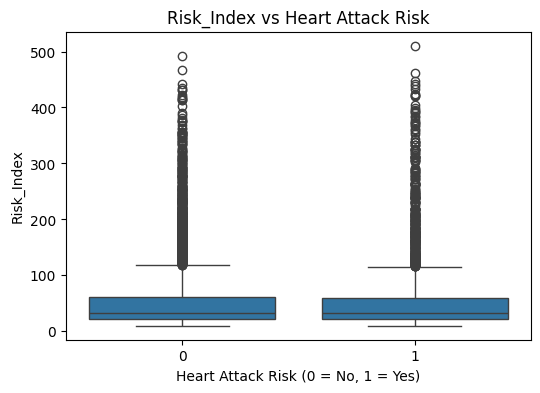

In [108]:
# Boxplot of Risk_Index by Heart Attack Risk
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Heart Attack Risk", y="Risk_Index")
plt.title("Risk_Index vs Heart Attack Risk")
plt.xlabel("Heart Attack Risk (0 = No, 1 = Yes)")
plt.ylabel("Risk_Index")
plt.show()


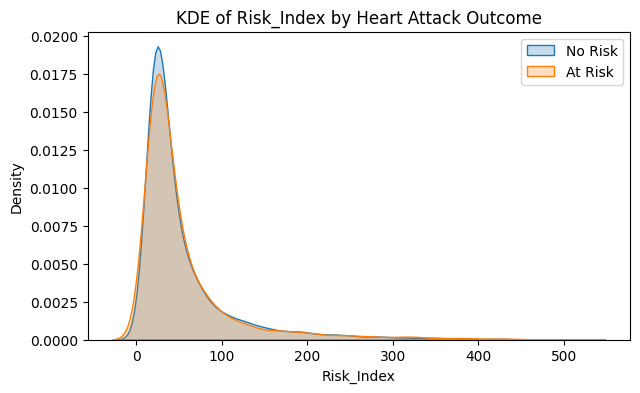

In [109]:
# KDE of Risk_Index by Heart Attack Outcome
plt.figure(figsize=(7,4))
sns.kdeplot(data=df[df["Heart Attack Risk"]==0]["Risk_Index"], label="No Risk", fill=True)
sns.kdeplot(data=df[df["Heart Attack Risk"]==1]["Risk_Index"], label="At Risk", fill=True)
plt.title("KDE of Risk_Index by Heart Attack Outcome")
plt.xlabel("Risk_Index")
plt.legend()
plt.show()


In [110]:
# Add new features to numeric_cols
numeric_cols.extend([
    'Systolic', 'Diastolic', 'BP_Ratio', 'Pulse_Pressure', 'HR_Age_Ratio',
    'Exer_Seden_Ratio', 'Exer_Activ_Ratio', 'Sleep_Stress_Ratio',
    'Trig_BMI_Ratio', 'ISH', 'IDH', 'MAP', 'Risk_Index'
])

Create categorical features

In [111]:
# Categorize blood pressure by medical standards
def bp_category(sys, dia):
    if sys >= 180 or dia >= 120:
        return "Hypertensive Crisis"
    elif sys >= 140 or dia >= 90:
        return "Hypertension Stage 2"
    elif sys >= 130 or dia >= 80:
        return "Hypertension Stage 1"
    elif sys >= 120 and dia < 80:
        return "Elevated"
    else:
        return "Normal"

df["BP_Category"] = df.apply(lambda row: bp_category(row["Systolic"], row["Diastolic"]), axis=1)

In [112]:
# Summarize BP categories
bp_counts = df["BP_Category"].value_counts().rename("count")
bp_perc = (df["BP_Category"].value_counts(normalize=True) * 100).round(2).rename("percent")

bp_summary = pd.concat([bp_counts, bp_perc], axis=1)
print(bp_summary)

                      count  percent
BP_Category                         
Hypertension Stage 2   5873    67.02
Hypertension Stage 1   1276    14.56
Normal                 1163    13.27
Elevated                353     4.03
Hypertensive Crisis      98     1.12


In [113]:
# Create BMI categories based on WHO guidelines
def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif bmi < 25:
        return "Normal"
    elif bmi < 30:
        return "Overweight"
    else:
        return "Obese"

df["BMI_Category"] = df["BMI"].apply(categorize_bmi)

In [114]:
# Summarize BMI categories
bmi_counts = df["BMI_Category"].value_counts().rename("count")
bmi_perc = (df["BMI_Category"].value_counts(normalize=True) * 100).round(2).rename("percent")

bmi_summary = pd.concat([bmi_counts, bmi_perc], axis=1)
print(bmi_summary)

              count  percent
BMI_Category                
Obese          3881    44.29
Normal         2619    29.89
Overweight     2059    23.50
Underweight     204     2.33


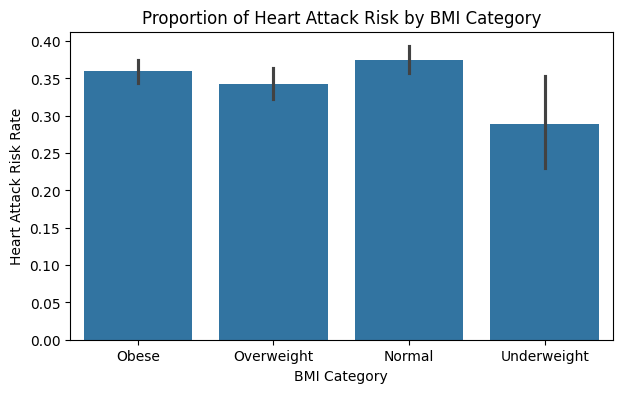

In [115]:
# Bar plot of Heart Attack Risk by BMI Category
plt.figure(figsize=(7,4))
sns.barplot(
    data=df,
    x="BMI_Category",
    y="Heart Attack Risk",
    estimator=lambda x: sum(x) / len(x)  # percentage with risk=1
)
plt.title("Proportion of Heart Attack Risk by BMI Category")
plt.ylabel("Heart Attack Risk Rate")
plt.xlabel("BMI Category")
plt.show()

Interaction terms

In [116]:
# Pairwise correlation with target using interaction terms

# Ensure target is excluded from numeric features
target = 'Heart Attack Risk'
nums = numeric_cols + ordinal_cols
num_feats = [c for c in nums if c != target]

if len(num_feats) < 2:
    print("Not enough numeric features to form interaction pairs.")
else:
    rows = []
    for a, b in combinations(num_feats, 2):
        prod = (df[a].astype(float) * df[b].astype(float)).dropna()
        target_series = df.loc[prod.index, target].astype(float).dropna()
        # align indices in case of mismatched NA patterns
        common_idx = prod.index.intersection(target_series.index)
        if len(common_idx) < 2:
            corr = np.nan
        else:
            corr = prod.loc[common_idx].corr(target_series.loc[common_idx])
        rows.append({
            'feature_a': a,
            'feature_b': b,
            'interaction': f'{a}*{b}',
            'corr': corr,
            'abs_corr': abs(corr) if pd.notnull(corr) else np.nan
        })

    interaction_corr_df = pd.DataFrame(rows).sort_values(by='abs_corr', ascending=False).reset_index(drop=True)

    # Display summary and top interactions
    print(f"Total interaction pairs evaluated: {len(interaction_corr_df)}")
    display(interaction_corr_df.head(20))  # show top 20 by absolute correlation

    # Keep interaction_corr_df in namespace for further use
    interaction_corr_df

Total interaction pairs evaluated: 276


c:\Users\ggibs\SuperDataScience\GitHub\SDS-CP043-cardiosentinel\advanced\submissions\team-members\greg-gibson\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ggibs\SuperDataScience\GitHub\SDS-CP043-cardiosentinel\advanced\submissions\team-members\greg-gibson\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,feature_a,feature_b,interaction,corr,abs_corr
0,Age,Pulse_Pressure,Age*Pulse_Pressure,0.025912,0.025912
1,Cholesterol,Systolic,Cholesterol*Systolic,0.024979,0.024979
2,Cholesterol,Pulse_Pressure,Cholesterol*Pulse_Pressure,0.023974,0.023974
3,Cholesterol,BP_Ratio,Cholesterol*BP_Ratio,0.023921,0.023921
4,Pulse_Pressure,Risk_Index,Pulse_Pressure*Risk_Index,0.023190,0.023190
5,Income,Pulse_Pressure,Income*Pulse_Pressure,0.023108,0.023108
6,Diastolic,Sleep Hours Per Day,Diastolic*Sleep Hours Per Day,-0.021883,0.021883
7,Cholesterol,BMI,Cholesterol*BMI,0.020754,0.020754
8,Pulse_Pressure,MAP,Pulse_Pressure*MAP,0.020531,0.020531
9,Systolic,Pulse_Pressure,Systolic*Pulse_Pressure,0.020430,0.020430


In [117]:
# Select top, non-overlap interactions from pairwise correlation
df["Age_x_PP"] = df["Age"] * df["Pulse_Pressure"]
df["Chol_x_Sys"] = df["Cholesterol"] * df["Systolic"]
df["Inc_x_PP"] = df["Income"] * df["Pulse_Pressure"]
df["Sleep_x_Dia"] = df["Sleep Hours Per Day"] * df["Diastolic"]
df["Chol_x_BMI"] = df["Cholesterol"] * df["BMI"]
df["Age_x_Trig"] = df["Age"] * df["Triglycerides"]

Encodings

In [118]:
# Map sex to binary
df["Sex"] = df["Sex"].map({"Male": 1, "Female": 0}).astype(int)

In [119]:
# Create a binary high risk indicator, clinical threshold for hypertension
df["BP_HighRisk"] = df["BP_Category"].str.startswith("Hyper").astype(int)

In [120]:
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=["Diet", "BMI_Category", "Country"], drop_first=True)

Removals

In [122]:
# Drop unnecessary columns
df = df.drop(columns=['BP_Category', 'Blood Pressure', 'Continent', 'Hemisphere'])

Final columns

In [123]:
# List column type groupings
groups = infer_column_groups(df, target_col="Heart Attack Risk")

for name, cols in groups.items():
    print(f"\n{name.upper()} columns:")
    for c in cols:
        print(f"  - {c}")


NUMERIC columns:
  - Age
  - Cholesterol
  - Heart Rate
  - Exercise Hours Per Week
  - Sedentary Hours Per Day
  - Income
  - BMI
  - Triglycerides
  - Systolic
  - Diastolic
  - BP_Ratio
  - Pulse_Pressure
  - MAP
  - HR_Age_Ratio
  - Exer_Seden_Ratio
  - Exer_Activ_Ratio
  - Sleep_Stress_Ratio
  - Trig_BMI_Ratio
  - Risk_Index
  - Age_x_PP
  - Chol_x_Sys
  - Inc_x_PP
  - Sleep_x_Dia
  - Chol_x_BMI
  - Age_x_Trig

BINARY columns:
  - Sex
  - Diabetes
  - Family History
  - Smoking
  - Obesity
  - Alcohol Consumption
  - Previous Heart Problems
  - Medication Use
  - ISH
  - IDH
  - BP_HighRisk
  - Diet_Healthy
  - Diet_Unhealthy
  - BMI_Category_Obese
  - BMI_Category_Overweight
  - BMI_Category_Underweight
  - Country_Australia
  - Country_Brazil
  - Country_Canada
  - Country_China
  - Country_Colombia
  - Country_France
  - Country_Germany
  - Country_India
  - Country_Italy
  - Country_Japan
  - Country_New Zealand
  - Country_Nigeria
  - Country_South Africa
  - Country_South K

Split training and testing

In [125]:
# Separate features and target
X = df.drop(columns=["Heart Attack Risk"])
y = df["Heart Attack Risk"]

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, round(y_train.mean(),3), round(y_test.mean(),3)

((7010, 63),
 (1753, 63),
 (7010,),
 (1753,),
 np.float64(0.358),
 np.float64(0.358))

Class weighting

In [127]:
print("Class distribution BEFORE weighting:")
print("Training set:")
print(y_train.value_counts(normalize=True).round(3))
print("\nTest set:")
print(y_test.value_counts(normalize=True).round(3))

Class distribution BEFORE weighting:
Training set:
Heart Attack Risk
0    0.642
1    0.358
Name: proportion, dtype: float64

Test set:
Heart Attack Risk
0    0.642
1    0.358
Name: proportion, dtype: float64


In [131]:
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, class_weights))

print("\nComputed class weights (used during training):")
print(class_weight_dict)


Computed class weights (used during training):
{np.int64(0): np.float64(0.7790620137808402), np.int64(1): np.float64(1.395858223815213)}
